In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Change the directory to your own working directory
# You code will be able to read and write files in your working directory
# TO DO: Enter the name of your directory
import os
os.chdir('/content/drive/MyDrive/Project')

Mounted at /content/drive


Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
# imports used for building the CNN model and data preprocessing
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave, imread
import os
import random
#Need to look for alternative libraries

Connect to a GPU

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Augmentations

In [ ]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True,
        rescale = 1/255)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(train_imayges, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = np.expand_dims(X_batch,axis=0)
        Y_batch = lab_batch[:,:,:,1:] / 128
        # Y_batch = np.expand_dims(Y_batch,axis=0)
        yield (X_batch, Y_batch)

# Train model      
model.fit(image_a_b_gen(batch_size), epochs=100)

Dataset Loading

In [ ]:
ds = tfds.load('lfw', data_dir="TFDS", split='train', shuffle_files=True,download=False)

In [ ]:
import cv2

train_images=[];
for i, img in enumerate(ds):
  if i < 3000:
    z = cv2.resize(np.array(img['image']), (256,256)).astype(np.uint8)
    train_images.append(z);
  else:
    break

In [ ]:
train_images = np.array(train_images);
train_images.shape

(2100, 256, 256, 3)

U-Net Definition

In [ ]:
def conv_block(x, n_filter,stride):
  x = layers.Conv2D(n_filter, 3, padding = "same", activation = "relu", strides=stride)(x)
  return x

In [ ]:
def upsample_block(x, n_filter):
  x = layers.UpSampling2D((2,2))(x)
  x = conv_block(x, n_filter,stride=1)
  x = layers.BatchNormalization()(x)
  return x

In [ ]:
def downsample_block(x, n_filter):
  x = conv_block(x, n_filter,stride=2)
  x = conv_block(x, n_filter,stride=1)
  x = layers.BatchNormalization()(x) 
  return x

In [ ]:
def model():
   inputs = layers.Input(shape=(256,256,1))

   # downsampler: contracting path 
   # 1 - downsample
   f1 = downsample_block(inputs, 32)
   # 2 - downsample
   f2= downsample_block(f1, 64)
   # 3 - downsample
   f3= downsample_block(f2, 128)
   # 4 - downsample
   f4= downsample_block(f3, 256)
  
   bottleneck = conv_block(f4,256,1)
   # upsampler: expanding path
   # 6 - upsample
   u5 = upsample_block(bottleneck, 128)
   # 7 - upsample
   u6 = upsample_block(u5, 64)
   # 8 - upsample
   u7 = upsample_block(u6, 32)
   # 9 - upsample
   u8 = upsample_block(u7, 16)
  #256*256*32
   # outputs
   outputs = layers.Conv2D(2, 3, padding="same", activation = "tanh")(u8)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

Data Preprocessing - RGB to CIELAB

In [ ]:
inp = train_images
inpShape= train_images.shape[0]
X=[];
Y=[];
for i in range(inpShape):
  # image = img_to_array(inp);
  image = np.array(inp[i], dtype=float)  
  X.append(rgb2lab(1.0/255*image)[:,:,0])
  Y.append(rgb2lab(1.0/255*image)[:,:,1:]/128);

X= tf.convert_to_tensor(np.array(X));
Y= tf.convert_to_tensor(np.array(Y));

Model Compile and Fit

In [ ]:
model=model()

In [ ]:
# # Finish model
model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

model.fit(x=X, 
    y=Y,
    batch_size=40,
    epochs=100,
    shuffle=True)

Saving model for future use

In [ ]:
model.save('u_net_model')

Model Test

In [ ]:
# Loading back the saved model

from tensorflow import keras
model = keras.models.load_model('u_net_model')

Sample block for instructors to test the model

In [ ]:
# Run this block to run the model on the selected image
import cv2
image = load_img('man.jpg') #Insert the image file's name to be colorized here
original_img = img_to_array(image).astype(np.uint8)
image = cv2.resize(original_img, (256,256), interpolation = cv2.INTER_AREA)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)

print(model.evaluate(X, Y, batch_size=10))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0,:]
# imsave("img_result.png", lab2rgb(cur))

1/1 [==============================] - 1s 686ms/step - loss: 0.0029 - accuracy: 0.4533
[0.002862840425223112, 0.4533233642578125]
1/1 [==============================] - 0s 196ms/step


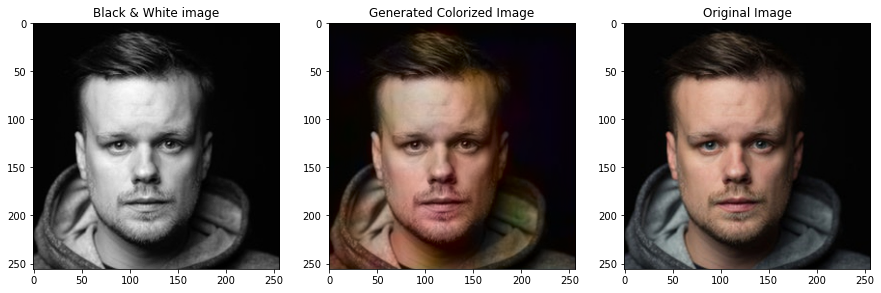

In [ ]:
# Run this block to get the output images
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Black & White image')
ax1.imshow(X.reshape(256,256), cmap='gray');

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Generated Colorized Image')
ax2.imshow(lab2rgb(cur));

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Original Image')
ax3.imshow((original_img));

Model Testing and Validation done by the authors

In [ ]:
#Testing the model trained on test images
import cv2
image = load_img('pogba_1.jpg')
original_img = img_to_array(image).astype(np.uint8)
image = cv2.resize(original_img, (256,256), interpolation = cv2.INTER_AREA)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)

print(model.evaluate(X, Y, batch_size=10))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0,:]
# imsave("img_result.png", lab2rgb(cur))

1/1 [==============================] - 0s 34ms/step - loss: 0.0080
0.008049191907048225
1/1 [==============================] - 0s 18ms/step


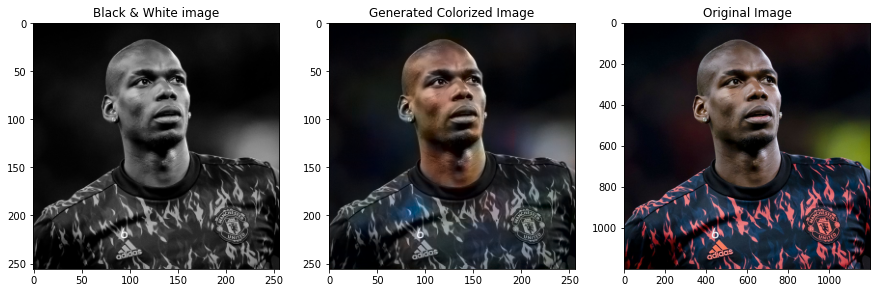

In [ ]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Black & White image')
ax1.imshow(X.reshape(256,256), cmap='gray');

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Generated Colorized Image')
ax2.imshow(lab2rgb(cur));

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Original Image')
ax3.imshow((original_img));

In [ ]:
import cv2
image = load_img('man_1.jpg')
original_img = img_to_array(image).astype(np.uint8)
image = cv2.resize(original_img, (256,256), interpolation = cv2.INTER_AREA)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)

print(model.evaluate(X, Y, batch_size=10))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0,:]
# imsave("img_result.png", lab2rgb(cur))

1/1 [==============================] - 0s 32ms/step - loss: 0.0037
0.0037091101985424757
1/1 [==============================] - 0s 16ms/step


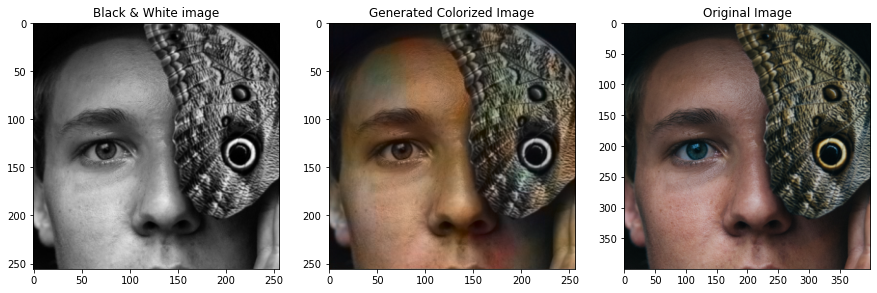

In [ ]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Black & White image')
ax1.imshow(X.reshape(256,256), cmap='gray');

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Generated Colorized Image')
ax2.imshow(lab2rgb(cur));

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Original Image')
ax3.imshow((original_img));

In [ ]:
import cv2
image = load_img('man_2.jpg')
original_img = img_to_array(image).astype(np.uint8)
image = cv2.resize(original_img, (256,256), interpolation = cv2.INTER_AREA)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)

print(model.evaluate(X, Y, batch_size=10))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0,:]


1/1 [==============================] - 0s 76ms/step - loss: 0.0034
0.003435671329498291
1/1 [==============================] - 0s 26ms/step


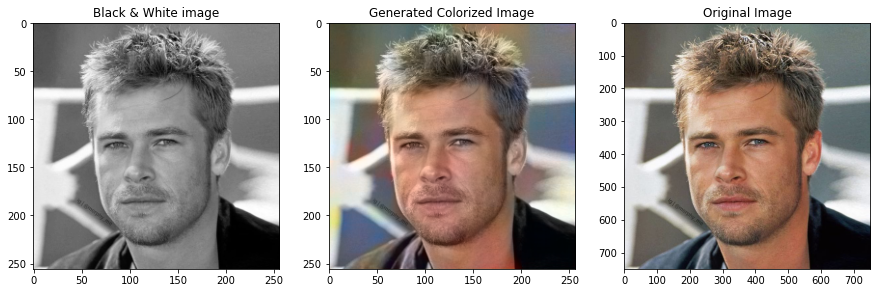

In [ ]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Black & White image')
ax1.imshow(X.reshape(256,256), cmap='gray');

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Generated Colorized Image')
ax2.imshow(lab2rgb(cur));
imsave("man_2_colorized.jpg", lab2rgb(cur))

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Original Image')
ax3.imshow((original_img));

In [ ]:
import cv2
image = load_img('woman_2.jpg')
original_img = img_to_array(image).astype(np.uint8)
image = cv2.resize(original_img, (256,256), interpolation = cv2.INTER_AREA)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)

print(model.evaluate(X, Y, batch_size=10))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0,:]
# imsave("img_result.png", lab2rgb(cur))

1/1 [==============================] - 8s 8s/step - loss: 0.0040
0.003963838797062635
1/1 [==============================] - 0s 209ms/step


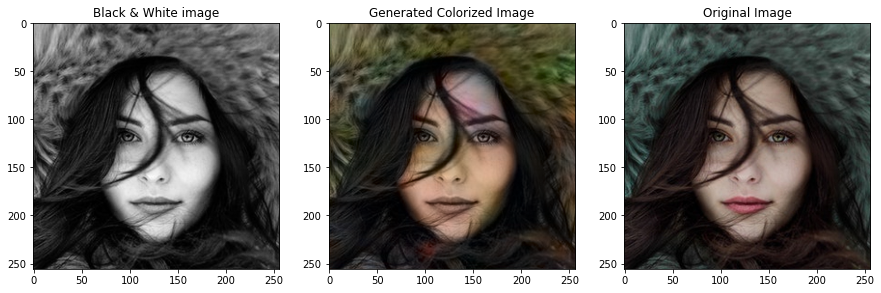

In [ ]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Black & White image')
ax1.imshow(X.reshape(256,256), cmap='gray');

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Generated Colorized Image')
ax2.imshow(lab2rgb(cur));

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Original Image')
ax3.imshow((original_img));

In [ ]:
# Object far away from the camera frame
import cv2
image = load_img('woman_3.jpg')
original_img = img_to_array(image).astype(np.uint8)
image = cv2.resize(original_img, (256,256), interpolation = cv2.INTER_AREA)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)

print(model.evaluate(X, Y, batch_size=10))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0,:]
# imsave("img_result.png", lab2rgb(cur))

1/1 [==============================] - 0s 38ms/step - loss: 0.0100
0.009965984150767326
1/1 [==============================] - 0s 16ms/step


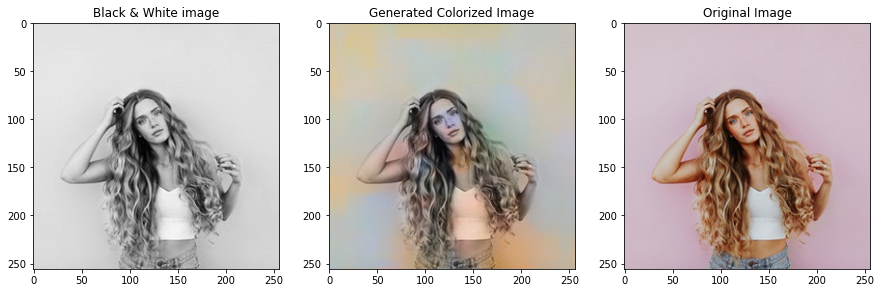

In [ ]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Black & White image')
ax1.imshow(X.reshape(256,256), cmap='gray');

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Generated Colorized Image')
ax2.imshow(lab2rgb(cur));

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Original Image')
ax3.imshow((original_img));

In [ ]:
# Object far away from the camera frame
import cv2
image = load_img('man_3.jpg')
original_img = img_to_array(image).astype(np.uint8)
image = cv2.resize(original_img, (256,256), interpolation = cv2.INTER_AREA)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)

print(model.evaluate(X, Y, batch_size=10))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0,:]
# imsave("img_result.png", lab2rgb(cur))

1/1 [==============================] - 0s 31ms/step - loss: 0.0138
0.013803020119667053
1/1 [==============================] - 0s 18ms/step


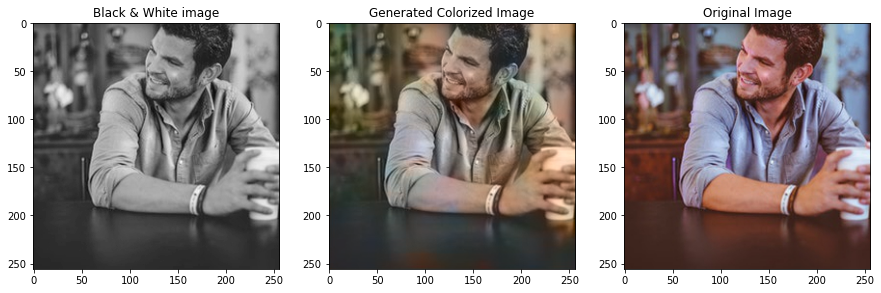

In [ ]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Black & White image')
ax1.imshow(X.reshape(256,256), cmap='gray');

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Generated Colorized Image')
ax2.imshow(lab2rgb(cur));

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Original Image')
ax3.imshow((original_img));

In [ ]:
# Testing on original B/W images
import cv2
image = load_img('bw_woman.jpg')
original_img = img_to_array(image).astype(np.uint8)
image = cv2.resize(original_img, (256,256), interpolation = cv2.INTER_AREA)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)

print(model.evaluate(X, Y, batch_size=10))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0,:]
# imsave("img_result.png", lab2rgb(cur))

1/1 [==============================] - 10s 10s/step - loss: 0.0012
0.0012022436130791903
1/1 [==============================] - 0s 306ms/step


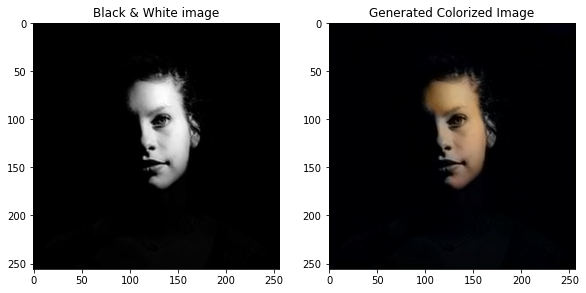

In [ ]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Black & White image')
ax1.imshow(X.reshape(256,256), cmap='gray');

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Generated Colorized Image')
ax2.imshow(lab2rgb(cur));

In [ ]:
# Testing on original B/W images
import cv2
image = load_img('bw_man.jpg')
original_img = img_to_array(image).astype(np.uint8)
image = cv2.resize(original_img, (256,256), interpolation = cv2.INTER_AREA)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 256, 256, 1)
Y = Y.reshape(1, 256, 256, 2)

print(model.evaluate(X, Y, batch_size=10))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((256, 256, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0,:]
# imsave("img_result.png", lab2rgb(cur))

1/1 [==============================] - 0s 32ms/step - loss: 0.0060
0.0059819635935127735
1/1 [==============================] - 0s 17ms/step


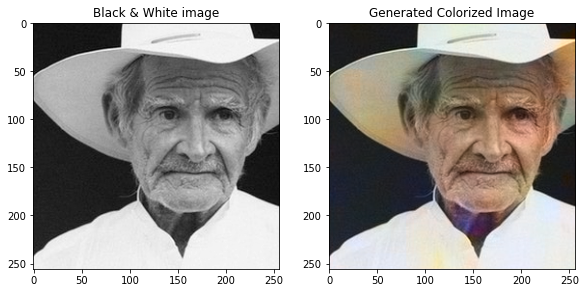

In [ ]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Black & White image')
ax1.imshow(X.reshape(256,256), cmap='gray');

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Generated Colorized Image')
ax2.imshow(lab2rgb(cur));
imsave("bw_man_colorized.jpg", lab2rgb(cur))

Video 

In [ ]:
# Splitting a video into frames
import cv2
def getFrame(sec,path,cap,count):
    if not os.path.exists(path):
      os.makedirs(path)
    cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = cap.read()
    if hasFrames:
        cv2.imwrite(f"{path}/frame%d.jpg" %count, image)     # save frame as JPG file
    return hasFrames

In [ ]:
def video_to_jpg(video_loc,image_path):
  cap= cv2.VideoCapture(video_loc)
  sec = 0
  frameRate = 0.5 #//it will capture image in each 0.5 second
  count=1
  success = getFrame(sec,image_path,cap,count)
  while success:
      count = count + 1
      sec = sec + frameRate
      sec = round(sec, 2)
      success = getFrame(sec,image_path,cap,count)
  return

In [ ]:
video_loc = '/content/drive/MyDrive/Project/landscape_video.mp4'
image_path = '/content/drive/MyDrive/Project/Frame_11.0'
video_to_jpg(video_loc,image_path)

Video Colorization

1/1 [==============================] - 0s 25ms/step


output size =  (1, 256, 256, 2)
1/1 [==============================] - 0s 23ms/step


output size =  (1, 256, 256, 2)
1/1 [==============================] - 0s 25ms/step


output size =  (1, 256, 256, 2)
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)


output size =  (1, 256, 256, 2)
1/1 [==============================] - 0s 21ms/step


output size =  (1, 256, 256, 2)
1/1 [==============================] - 0s 22ms/step


output size =  (1, 256, 256, 2)
1/1 [==============================] - 0s 22ms/step


output size =  (1, 256, 256, 2)
1/1 [==============================] - 0s 25ms/step


output size =  (1, 256, 256, 2)
1/1 [==============================] - 0s 20ms/step


output size =  (1, 256, 256, 2)
1/1 [==============================] - 0s 25ms/step


output size =  (1, 256, 256, 2)
1/1 [==============================] - 0s 20ms/step


output size =  (1, 256, 256, 2)


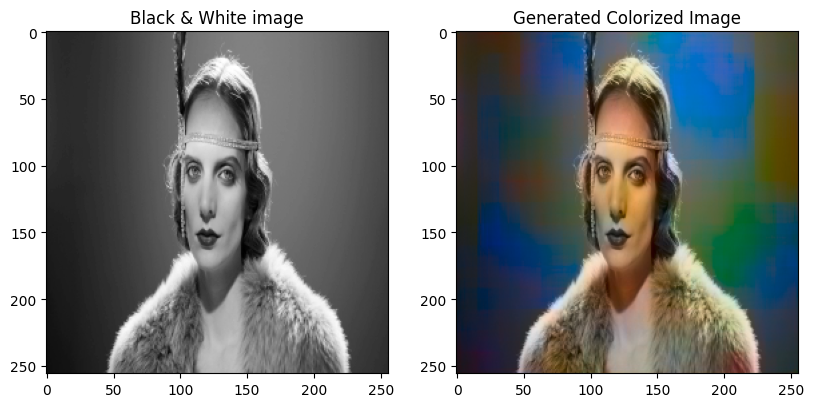

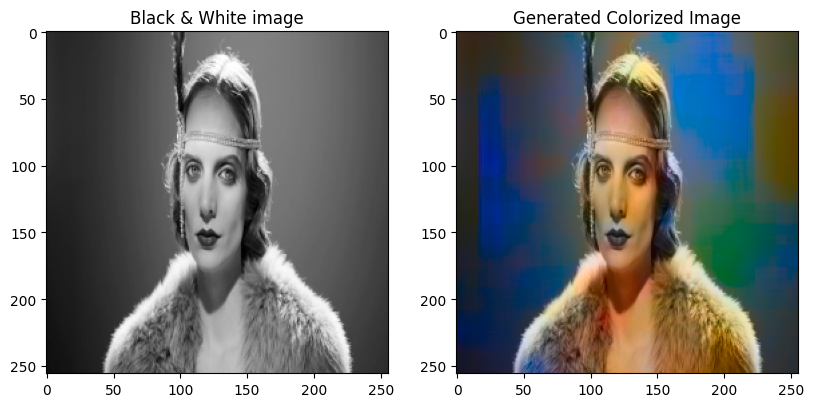

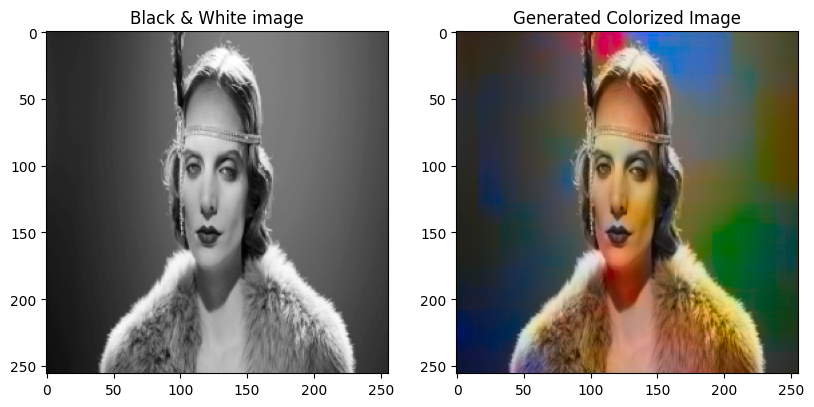

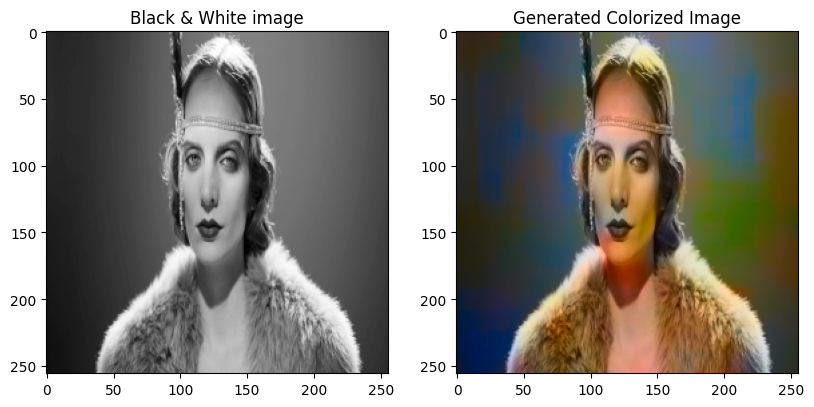

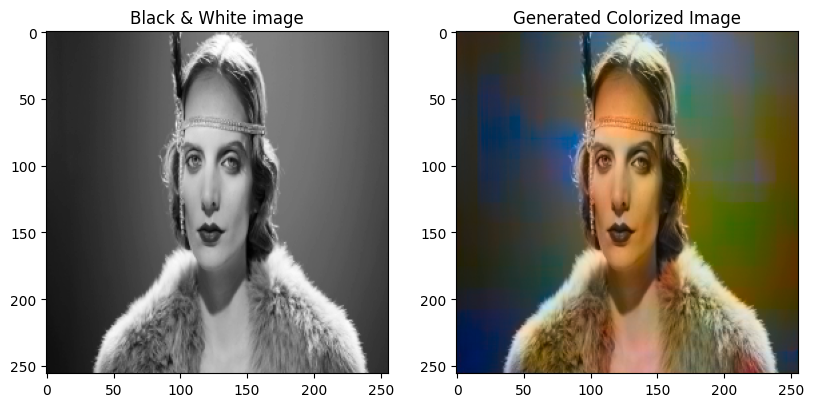

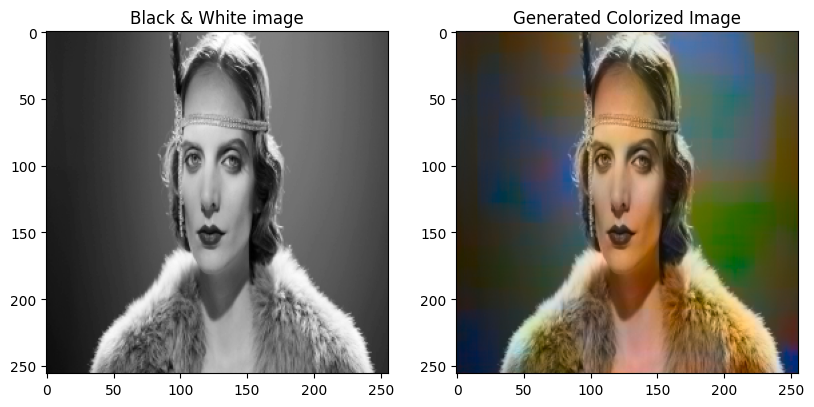

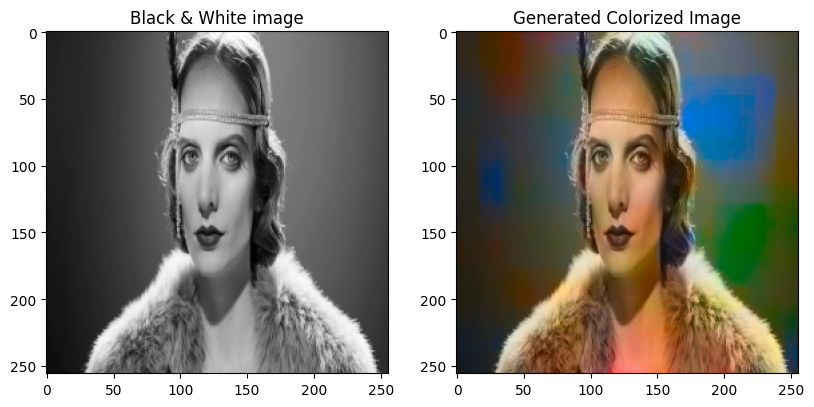

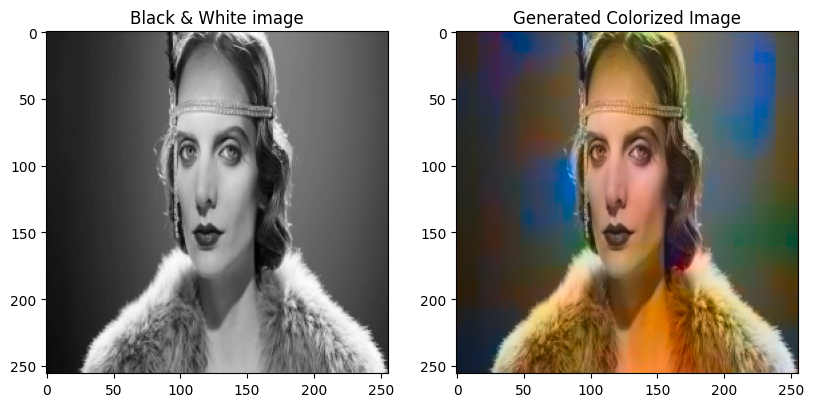

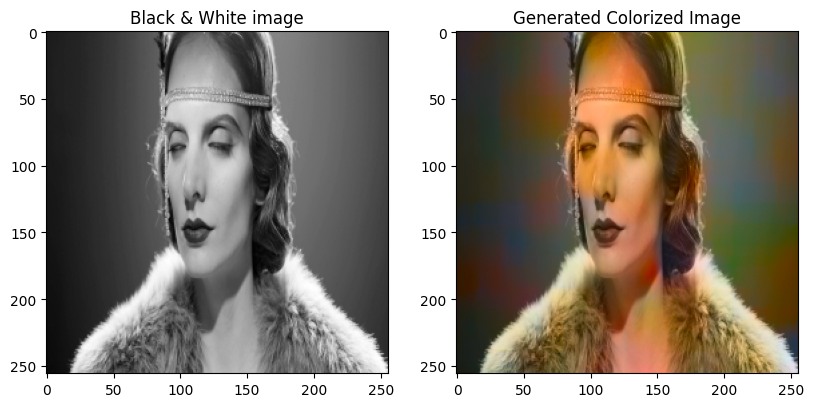

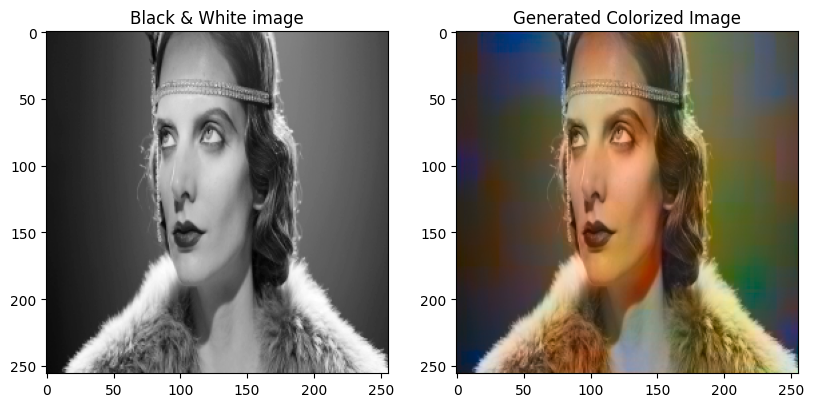

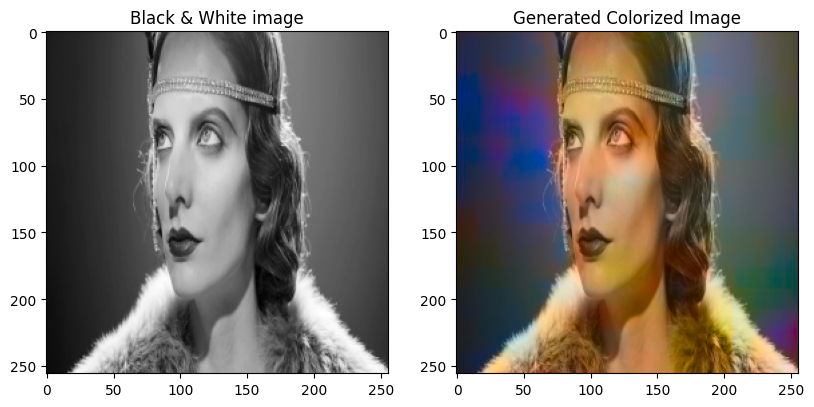

In [ ]:
#Testing the model trained on black and white Video image frames dataset
image_folder = image_path

for images in os.listdir(image_folder): 
    # check if the image ends with jpg
    if (images.endswith(".jpg")):
      image_fileNumber= images.index     
      image = load_img(os.path.join(image_folder,images))
      original_img = img_to_array(image).astype(np.uint8)
      image = cv2.resize(original_img, (256,256), interpolation = cv2.INTER_AREA)    
     
      X = rgb2lab(1.0/255*image)[:,:,0]
      Y = rgb2lab(1.0/255*image)[:,:,1:]
      Y /= 128
      X = X.reshape(1, 256, 256, 1)
      Y = Y.reshape(1, 256, 256, 2)        

      # print(model.evaluate(X, Y, batch_size=10))
      output = model.predict(X)
      output *= 255
      print("output size = ", output.shape)
      # Output colorizations
      cur = np.zeros((256, 256, 3))
      cur[:,:,0] = X[0][:,:,0]
      cur[:,:,1:] = output[0,:]
      cur= lab2rgb(cur);    

      fig = plt.figure(figsize=(15,15))
      ax1 = fig.add_subplot(1,3,1)
      ax1.set_title('Black & White image')
      ax1.imshow(X.reshape(256,256), cmap='gray');

      ax2 = fig.add_subplot(1,3,2)
      ax2.set_title('Generated Colorized Image')
      ax2.imshow((cur));
      # cur=cv2.cvtColor(cur*255, cv2.COLOR_RGB2BGR)
      # cv2.imwrite("/content/drive/MyDrive/Project/Frames_6.0_WomanVideo/" + images, cur*255)
      path = os.path.join(image_folder,"_WomanVideo")
      if not os.path.exists(path):
        os.makedirs(path)
      imsave(os.path.join(path, images), cur)

# imsave("img_result.png", lab2rgb(cur))

Converting Colorized frames to a video

In [25]:
# Concatenating frames back into a video and saving the video in the drive
import os

image_folder = path
video_name = 'new_video_woman_concatenated_rgbVersion.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
video = cv2.VideoWriter(video_name, fourcc, 5.0, (width,height)) #(video_name, fourcc codec, fps, (wd,ht of the final video))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()